In [1]:
import siibra
from nilearn import plotting

[siibra:INFO] Version: 0.3a4
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
/usr/local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Assignment of an MNI coordinate to Julich-Brain probabilistic cytoarchitectonic maps
`siibra` can use the probabilistic maps of the Julich-Brain cytorachitectonic atlas to make a probabilistic assignment of a coordinate with error radius (modelled as a Gaussian) to brain regions.

In [2]:
# some coordinates  in MNI space, e.g. from an EEG contact
points = siibra.PointSet([
    (31.0, -89.6, -6.475),  # a real sEEG contact point
    (27.75, -32.0, 63.725)    # this should be in PostCG, right hemisphere
          ], space="mni152")

# a confidence radius for the coordinate, i.e. the expected localization error.
radius_mm = 5

We instantiate the human atlas with the Julich-brain probabilistic cytoarchitectonic maps, and then ask it to assign regions. It will return a sorted list of probabilities with the corresponding regions. 

In [4]:
atlas = siibra.atlases.MULTILEVEL_HUMAN_ATLAS
julich_pmaps = atlas.get_map(
    space="mni152", 
    parcellation="julich",
    maptype="continuous")
assignments = julich_pmaps.assign_coordinates(points,radius_mm)

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9
[siibra:INFO] A GiftiSurfaceLabeling object was registered, but this type is not yet explicitly supported.
[siibra:INFO] Loading continuous map index for 296 brain regions.
[siibra:INFO] Constructed ContinuousParcellationMap for Julich-Brain Cytoarchitectonic Maps 2.9 with 296 maps.
[siibra:INFO] Assigning 3 uncertain coordinates (stderr=5) to 296 maps.
100%|██████████| 296/296 [00:02<00:00, 110.53it/s]


We look at the best fitting maps at the first requested location.

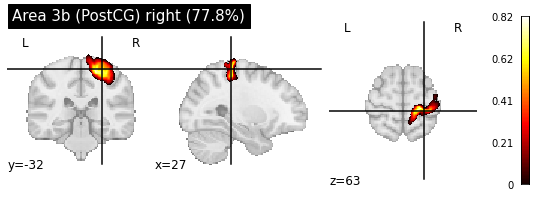

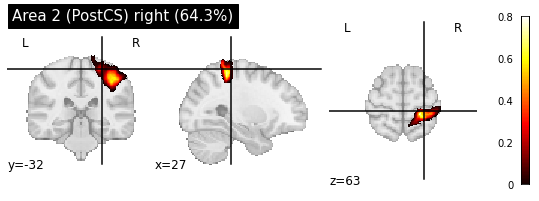

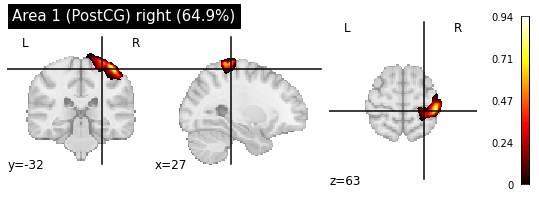

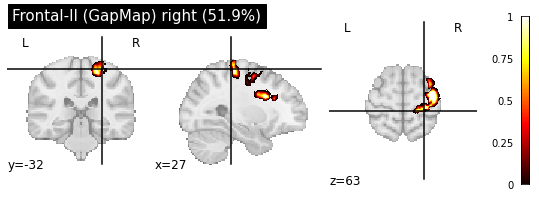

In [7]:
for region, mapindex, scores in assignments[0]:
    if scores['contains']>.5: 
        plotting.plot_stat_map(
            julich_pmaps.fetch(mapindex), 
            cut_coords=tuple(points[0]),
            title=f"{region.name} ({scores['contains']*100:.1f}%)"
        )

# Connectivity profiles of the most probable brain region

`siibra`'s key feature is access to regional data features, including connectivity profiles from different projects. This can be used to check the connection strengh of the most likely region assignment to the MNI coordinate.

In [8]:
# get profiles for the top assigned region 
closest_region, mapindex, scores = next(iter(assignments[0]))
profiles = siibra.get_features(
    closest_region,
    siibra.modalities.ConnectivityProfile)

We will create plots of the connection strength to the 20 most strongly connected regions, for each of the returned profiles. Note that the profiles come from different connectivity datasets. The `src_info` and `src_name` attributes tell us more about each dataset.

First, we decode the profiles with the parcellation object. This will convert the column names of the connectivity profile to explicit brain region objects, helping to disambiguiate region names.

In [9]:
with siibra.QUIET:
    decoded_profiles = [
        p.decode(closest_region.parcellation)
        for p in profiles]
p = decoded_profiles[0]
target_regions = [region for strength,region in p[:20]]
target_regions

[Area 3b (PostCG) right,
 Frontal-II (GapMap) right,
 Area 1 (PostCG) right,
 Area PFt (IPL) right,
 Area OP4 (POperc) right,
 Area 6d1 (PreCG) right,
 Area PGa (IPL) right,
 Area PFm (IPL) right,
 Area 3a (PostCG) right,
 Frontal-II (GapMap) left,
 Temporal-to-Parietal (GapMap) right,
 Area 4a (PreCG) right,
 Area 4p (PreCG) right,
 Area OP1 (POperc) right,
 Area 6d2 (PreCG) right,
 Area 2 (PostCS) right,
 Area 6d1 (PreCG) left,
 Area 45 (IFG) right,
 Area Id5 (Insula) right,
 Area hIP2 (IPS) right]

We build a plotting function for the decoded profiles, which takes the N most strongly connected regions of the first profile, and then plots the connection strengths of all found profiles for those N target regions.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# a function to create a nice plot of multiple profiles from different
# data sources
def plot_connectivity_profiles(profiles,target_regions):
    # Let's plot the so obtained regions and their strenghts
    N = len(target_regions)
    xticks = range(N)
    fig  = plt.figure()
    ax1  = fig.add_subplot(211)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(
        [r.name for r in target_regions], 
        rotation=45, fontsize=10, ha='right')
    
    for p in profiles:
        probs = {region:prob for prob,region in p}
        y = [probs[r] if r in probs else 0 
             for r in target_regions ]
        strengths = []
        ax1.plot(xticks,y,'.-',lw=1)

    ax1.grid(True)
    return fig

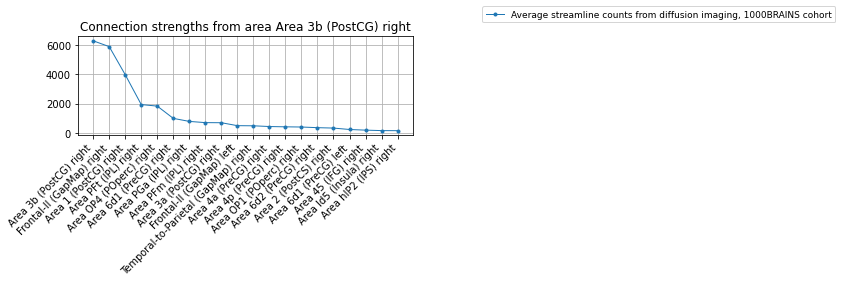

In [11]:
fig = plot_connectivity_profiles(decoded_profiles,target_regions)
fig.legend([p.name for p in profiles],
           loc='upper left', bbox_to_anchor=(1.05, 1.0),
           prop={'size': 9})
fig.gca().set_title(f"Connection strengths from area {closest_region.name}")
plt.show()